In [62]:
import numba as nb
import numpy as np
import pandas as pd
import re
from functools import reduce
import math
from math import log
import time
from typing import List, Set, Dict

In [39]:
training_base_df = pd.read_csv("trg.csv")

In [40]:
training_base_df.head()

,id,class,abstract
0,1,B,the 4 202 353 bp genome of the alkaliphilic ba...
1,2,A,the complete 1751377-bp sequence of the genome...
2,3,E,in 1992 we started assembling an ordered libra...
3,4,E,the aim of this study is to measure human mito...
4,5,B,the amino acid sequence of the spirulina maxim...


In [41]:
class CrossValidation():
    def __init__(self, dataframe, num_split=10):
        self.df = dataframe
        self.split = num_split
        self.dfs = self.shuffle_and_split()
        self.classifiers = []
    
    def shuffle_and_split(self, random_state=42): # add random state parameter so that it can be replicated
        self.df = self.df.sample(frac=1, random_state = random_state) # shuffle by resampling the whole dataset 
        return np.split(self.df, self.split, axis=0) # split the dataset 
    
    def get_ith_cv(self,i):
        i%=self.split
        train = []
        test = self.dfs[i]
        test.reset_index(drop=True, inplace=True)
        for x in range(self.split):
            if x == i:
                continue
            train.append(self.dfs[i])
        train = pd.concat(train, axis=0, join='outer', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=False)
        train.reset_index(drop=True, inplace=True)
        return train,test
    
    def train_and_validate(self):
        
        accuracy = np.zeros(self.split, dtype=float)
        for i in range(self.split):
            print("Fold ",i+1)
            train_df, test_df = self.get_ith_cv(i)
            classifier = MultinomialNBC()
            classifier.train(train_df)
            predictions = classifier.predict(test_df)
            Y_test = test_df["class"]
            accuracy[i] = get_accuracy(Y_test, predictions)
            print(accuracy[i])
            self.classifiers.append(classifier)
        return accuracy
    
            
            
            


In [42]:
crossval_data = CrossValidation(training_base_df)

In [55]:
class MultinomialNBC():
    classes = []
    num_class = 0
    class_mapping = dict()
    reverse_class_mapping = dict()
    word_mapping = dict()
    reverse_word_mapping = dict()
    word_counts = []
    probs = []
    num_unique_words = 0
    alpha_i = 1
    
    def train(self, train_data):
        y = train_data["class"]
        x = train_data["abstract"]
        self.classes , self.classes_count = np.unique(y, return_counts=True)
        self.num_class = len(self.classes)
        print("number of classes found in train data:",self.num_class)
        print("classes: ", self.classes)
        for i in range(self.num_class):
            self.class_mapping[self.classes[i]]=i
            self.reverse_class_mapping[i] = self.classes[i]
        
        print("Finished preprocess classes: ", time.perf_counter())
        self.get_overall_word_count(x)
        print("Finished count in overall words: ",time.perf_counter())
        
        print("number of unique words=",self.num_unique_words)
#         print(self.word_counts)
        self.word_counts_per_category = np.zeros([self.num_class, self.num_unique_words], dtype=int) 
        self.probs = np.zeros([self.num_class, self.num_unique_words], dtype=float) 
        for i in range(len(x)):
            words, counts = np.unique(self._get_sanitized_wordlist(x[i]), return_counts=True)
            for j in range(len(words)):
                self.word_counts_per_category[self.class_mapping[y[i]]][self.word_mapping[words[j]]]+=counts[j]
        # print(word_counts_per_category.shape)
        print("finished counting words per category: ",time.perf_counter())
        for i in range(self.num_class):
            for j in range(self.num_unique_words):
                self.probs[i][j] = log((self.word_counts_per_category[i][j] + 1)) - \
                    log((self.word_counts[j] + self.num_unique_words* self.alpha_i))              
        # print(self.probs)
        print("Training finished")
        print(time.perf_counter()) 
        return self.probs
        
    
    def _get_sanitized_wordlist(self, sentence):
        wordlist = [x.strip().lower() for x in sentence.split(' ')] # split by space then make it lowercase
        for i in range(len(wordlist)):
            wordlist[i] = re.sub('[^a-z]+', '', wordlist[i]) # Remove everything that is not related to alphabet
        return wordlist
    
    def _construct_word_dictionary(self, sentence, word_dict= {}):
        wordlist = self._get_sanitized_wordlist(sentence)
        for word in wordlist:
            if word in word_dict:
                word_dict[word] += 1
            else:
                word_dict[word] = 1
        return word_dict
        
    
    def get_overall_word_count(self, data):
        word_dict = dict()
        
        for abstract in data:
            word_dict = self._construct_word_dictionary(abstract, word_dict= word_dict)
#         print(word_dict)
            
        self.word_counts = np.zeros(len(word_dict), dtype =int)
        for key,value in word_dict.items():
            self.word_mapping[key] = self.num_unique_words
            self.reverse_word_mapping[self.num_unique_words] = key
            self.word_counts[self.num_unique_words] = value
            self.num_unique_words+=1
            
    
    def predict(self, test_data):
        x = test_data["abstract"]
        prediction_probs = np.zeros([len(x), self.num_class], dtype=float)
        for i in range(len(x)):
            words, counts = np.unique(self._get_sanitized_wordlist(x[i]), return_counts=True)
            sigma_fi_fact = log(math.factorial(sum(counts)))
            pi_fi_fact = 0
            for k in range(len(words)): 
                pi_fi_fact+= log(math.factorial(counts[k]))
            # print(pi_fi_fact)
            # print("verify nonzero:",len(counts) == np.count_nonzero(counts))
            # print(sigma_fi_fact, pi_fi_fact)
            for j in range(self.num_class):
                prediction_probs[i][j] = sigma_fi_fact - pi_fi_fact
                for k in range(len(words)):
                    if words[k] not in self.word_mapping:
                        continue
                    word_index = self.word_mapping[words[k]]
                    prediction_probs[i][j]+= self.probs[j][word_index] * counts[k]
        predictions = [''] * len(x)
        for i in range(len(x)):
            prediction_i = np.argmax(prediction_probs[i], axis=0)
            predictions[i] = self.reverse_class_mapping[prediction_i]
        return predictions
 

In [56]:
train_df, test_df = crossval_data.get_ith_cv(1)

In [57]:
classifier = MultinomialNBC()
probs = classifier.train(train_df[:])
print(probs[0])
print(classifier.word_counts_per_category[0][:10])

number of classes found in train data: 4
classes:  ['A' 'B' 'E' 'V']
Finished preprocess classes:  28805.8067623
Finished count in overall words:  28806.6084974
number of unique words= 7465
finished counting words per category:  28812.8984393
Training finished
28812.9450263
[-3.72847954 -8.94062918 -8.97765141 ... -8.91918561 -8.91918561
 -8.91918561]
[1152    0    0    0    0   36   81    9   18  108]


In [58]:
predictions = classifier.predict(test_df)
Y_test = test_df["class"]


In [59]:
def get_accuracy(test, predictions):
    correct = 0 
    false = 0 
    for i in range(len(test)):
        if test[i]==predictions[i]:
            correct+=1
        else:
            false+=1
    return correct/(correct+false)

In [60]:
get_accuracy(Y_test, predictions)

0.9475

In [12]:
overall_accuracy = crossval_data.train_and_validate()

Fold  0
number of classes found in train data: 4
classes:  ['A' 'B' 'E' 'V']
Finished preprocess classes:  44.4671849
Finished count in overall words:  45.2812154
number of unique words= 7475
finished counting words per category:  51.9135045
Training finished
51.9581452
0.9375
Fold  1
number of classes found in train data: 4
classes:  ['A' 'B' 'E' 'V']
Finished preprocess classes:  52.4185684
Finished count in overall words:  53.2175392
number of unique words= 7465
finished counting words per category:  59.6133104
Training finished
59.6584804
0.9475
Fold  2
number of classes found in train data: 4
classes:  ['A' 'B' 'E' 'V']
Finished preprocess classes:  60.0985869
Finished count in overall words:  60.9413268
number of unique words= 7599
finished counting words per category:  67.7370601
Training finished
67.782627
0.9425
Fold  3
number of classes found in train data: 4
classes:  ['A' 'B' 'E' 'V']
Finished preprocess classes:  68.2495212
Finished count in overall words:  69.0886342
numb

In [61]:
overall_accuracy

array([0.9375, 0.9475, 0.9425, 0.915 , 0.92  , 0.9125, 0.9125, 0.915 ,
       0.95  , 0.9175])

In [33]:
sum(overall_accuracy)/len(overall_accuracy)

0.9269999999999999

# Get the final model

In [14]:
classifier = MultinomialNBC()
classifier.train(training_base_df)

number of classes found in train data: 4
classes:  ['A' 'B' 'E' 'V']
Finished preprocess classes:  800.0350984
Finished count in overall words:  800.9515563
number of unique words= 25069
finished counting words per category:  808.360871
Training finished
808.5155737


In [36]:
# Sanity check 
predictions = classifier.predict(test_df)
Y_test = test_df["class"]
get_accuracy(Y_test, predictions)

0.8825

In [16]:
test_base_df = pd.read_csv("tst.csv")

In [18]:
test_base_predictions = classifier.predict(test_base_df)
test_base_predictions

['B',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'B',
 'E',
 'E',
 'E',
 'E',
 'B',
 'B',
 'E',
 'E',
 'E',
 'E',
 'E',
 'B',
 'B',
 'E',
 'B',
 'B',
 'E',
 'E',
 'E',
 'E',
 'B',
 'E',
 'E',
 'B',
 'E',
 'E',
 'B',
 'E',
 'E',
 'E',
 'B',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'B',
 'B',
 'E',
 'E',
 'E',
 'E',
 'B',
 'B',
 'E',
 'E',
 'B',
 'B',
 'E',
 'E',
 'E',
 'E',
 'B',
 'E',
 'B',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'B',
 'B',
 'E',
 'E',
 'B',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'B',
 'E',
 'E',
 'E',
 'B',
 'B',
 'E',
 'E',
 'E',
 'E',
 'E',
 'B',
 'E',
 'B',
 'E',
 'E',
 'E',
 'B',
 'E',
 'E',
 'E',
 'B',
 'B',
 'E',
 'E',
 'B',
 'B',
 'E',
 'B',
 'B',
 'E',
 'E',
 'B',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'B',
 'E',
 'E',
 'E',
 'E',
 'E',
 'B',
 'B',
 'E',
 'B',
 'B',
 'E',
 'B',
 'E',
 'E',
 'B',
 'E',
 'E',
 'E',
 'B',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'B',
 'B',
 'B',
 'E',
 'E',
 'E',
 'E',
 'B',
 'B',
 'E',
 'E',
 'E'

In [30]:
answers = df = pd.DataFrame(list(zip( list(range(1,len(test_base_predictions)+1)) ,test_base_predictions)), columns=['id','class'])
answers

,id,class
0,1,B
1,2,E
2,3,E
3,4,E
4,5,E
...,...,...
995,996,E
996,997,E
997,998,E
998,999,E


In [32]:
df.to_csv ('answers.csv', index = False, header=True)

In [34]:
import scikitplot as skplt # used only for verifying results 

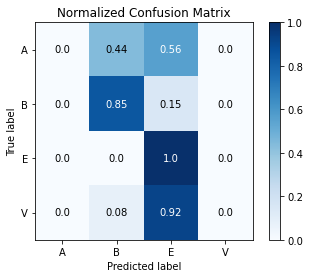

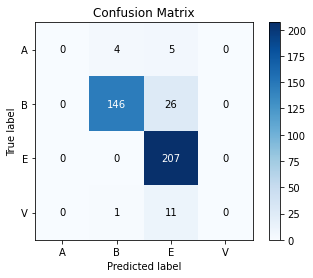

In [37]:
skplt.metrics.plot_confusion_matrix(Y_test, predictions, normalize=True)
skplt.metrics.plot_confusion_matrix(Y_test, predictions, normalize=False)
